In [1]:
import os
import pandas as pd

from pyannote.core import Segment, Annotation
from pyannote.metrics.diarization import DiarizationErrorRate
metric = DiarizationErrorRate()

In [2]:
def txt2annotation(path_txt, annotation=Annotation()):
    #check if file is txt of csv
    if path_txt.endswith('.txt'):
        with open(path_txt, 'r') as f:
            for line in f:
                if len(line) == 0:
                    continue
                start, end, speaker = line.split()
                speaker = speaker.lower()
                annotation[Segment(float(start), float(end))] = speaker
            return annotation
    elif path_txt.endswith('.csv'):
        diarization = pd.read_csv(path_txt)
        for index, row in diarization.iterrows():
            start = row['start [s]']
            end = row['end [s]']
            speaker = row['speaker']
            annotation[Segment(float(start), float(end))] = speaker
        return annotation

# Primero, una prueba sencilla

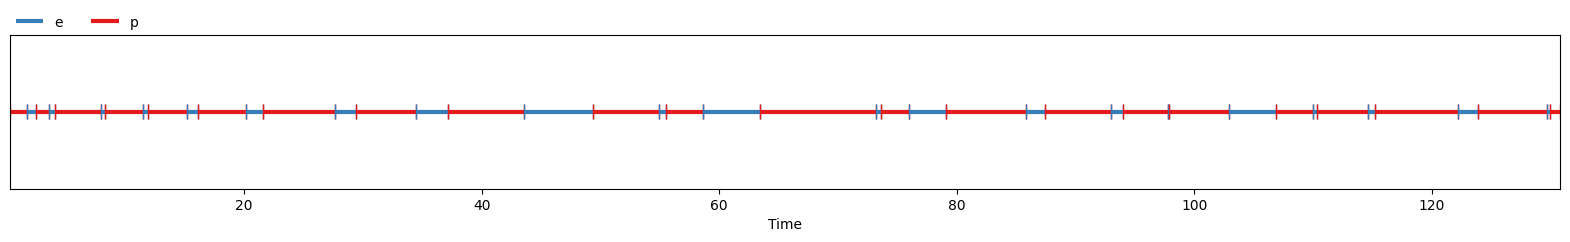

In [3]:
# reference annotation
reference_path = os.path.join('/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/UCSF_manual_prepro/UCSF__24651_01-24-25__PictureDescription.txt')
reference = txt2annotation(reference_path, annotation=Annotation(uri='test'))
reference

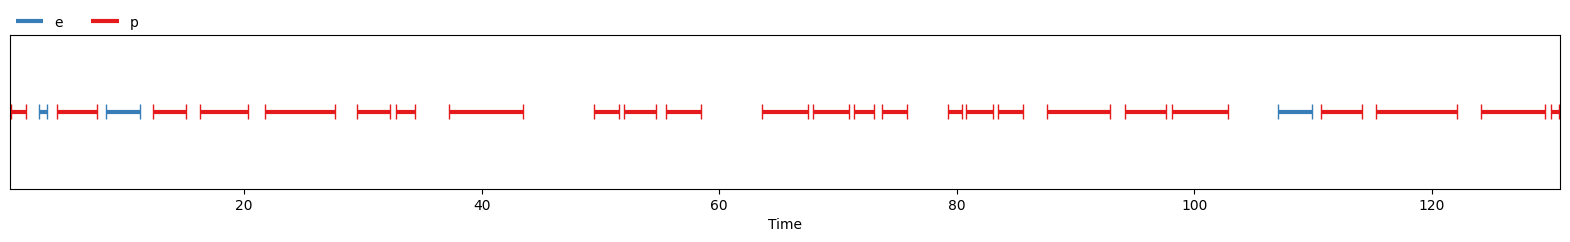

In [4]:
# hypothesis annotation
hypothesis_path = os.path.join('/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/UCSF_manual/UCSF__24651_01-24-25__PictureDescription.txt')
hypothesis = txt2annotation(hypothesis_path, annotation=Annotation(uri='test'))
hypothesis

In [4]:
# DER
metric(reference, hypothesis, detailed=True)

NameError: name 'reference' is not defined

In [6]:
# full report and reset metric
report = metric.report(display=True)
metric.reset()

      diarization error rate  total correct correct false alarm false alarm missed detection missed detection confusion confusion
                           %                      %                       %                                 %                   %
item                                                                                                                             
test                   37.49 130.48   81.56   62.51        0.00        0.00            42.42            32.51      6.50      4.98
TOTAL                  37.49 130.48   81.56   62.51        0.00        0.00            42.42            32.51      6.50      4.98


# Ahora obtengamos un DER para todos los pares reference - hypothesis de una base

# REDLAT

In [27]:
import warnings
import os
warnings.filterwarnings("ignore")

count = 0
# find all txt files in reference directory
reference_dir = os.path.join('UCSF_manual')
reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
# os walk to find all txt files in reference directory
for root, dirs, files in os.walk(reference_dir):
        for file in files:
            if file.endswith('.txt'): 
                try:
                    reference_path = (os.path.join(root, file))
                    annotation = Annotation(uri=file)
                    # print(reference_path)
                    reference = txt2annotation(reference_path, annotation)
                    print(reference)

                    # find corresponding hypothesis file
                    hypothesis_path = reference_path.replace('_manual', 'manual_prepro')
                    directory, filename = os.path.split(hypothesis_path)
                    #hypothesis_path = os.path.join(directory, 'diarization_min_max', filename.replace('.txt', '_diarization.csv'))
                    annotation = Annotation(uri=file)
                    hypothesis = txt2annotation(hypothesis_path, annotation)
                    print(hypothesis)
                    # compute DER
                    metric(reference, hypothesis, detailed=True)
                except:
                    # print('Error in file:', reference_path)
                    # print(reference_path)
                    # log reference_path to file
                    with open('error_log.txt', 'a') as f:
                        f.write(reference_path)
                        f.write('\n')
                    count += 1
                    # print(count)


# cumulative report

print(abs(metric))
report = abs(metric.report(display=True))
report.to_csv('DER_report_UCSF.csv')
metric.reset() # reset metric for next iteration
print('Total number of files with errors:', count)

[ 00:00:02.470 -->  00:00:39.264] _ p
[ 00:00:39.970 -->  00:02:07.941] _ p
[ 00:02:10.324 -->  00:02:17.383] _ p
[ 00:02:17.824 -->  00:03:53.912] _ p
[ 00:03:54.618 -->  00:04:49.236] _ p
[ 00:04:50.295 -->  00:06:01.589] _ p
[ 00:06:02.648 -->  00:06:23.295] _ p
[ 00:00:01.031 -->  00:00:02.504] _ e
[ 00:00:05.892 -->  00:00:06.408] _ e
[ 00:00:10.091 -->  00:00:13.701] _ e
[ 00:00:15.174 -->  00:00:53.846] _ p
[ 00:00:56.498 -->  00:00:59.003] _ p
[ 00:01:03.570 -->  00:01:04.307] _ p
[ 00:01:05.338 -->  00:01:07.621] _ e
[ 00:00:01.927 -->  00:00:06.639] _ e
[ 00:00:15.849 -->  00:00:17.177] _ p
[ 00:00:17.177 -->  00:00:22.061] _ e
[ 00:00:22.275 -->  00:00:28.272] _ p
[ 00:00:29.172 -->  00:00:31.228] _ p
[ 00:00:31.613 -->  00:00:33.969] _ p
[ 00:00:34.955 -->  00:00:39.067] _ p
[ 00:00:39.881 -->  00:00:41.295] _ p
[ 00:00:42.323 -->  00:00:46.007] _ p
[ 00:00:46.778 -->  00:00:49.605] _ p
[ 00:00:50.248 -->  00:00:54.488] _ p
[ 00:00:55.217 -->  00:00:58.901] _ p
[ 00:00:59.3

In [ ]:
# DER report based on PM code

codes = ['AF', 'BE', 'BN','CU', 'LO', 'MA','SL']

for code in codes:
    # find all txt files in reference directory
    reference_dir = os.path.join('REDLAT', 'reference')
    reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
    # os walk to find all txt files in reference directory
    for root, dirs, files in os.walk(reference_dir):
            for file in files:
                if file.endswith('.txt') and code in file:
                    try:
                        reference_path = (os.path.join(root, file))
                        annotation = Annotation(uri=file)
                        # print(reference_path)
                        reference = txt2annotation(reference_path, annotation)

                        # find corresponding hypothesis file
                        hypothesis_path = reference_path.replace('reference', 'hypothesis')
                        directory, filename = os.path.split(hypothesis_path)
                        hypothesis_path = os.path.join(directory, 'diarization_min_max', filename.replace('.txt', '_diarization.csv'))
                        annotation = Annotation(uri=file)
                        hypothesis = txt2annotation(hypothesis_path, annotation)

                        # compute DER
                        metric(reference, hypothesis, detailed=True)
                    except Exception as e:
                        print(e)
                        print('Error in file:', reference_path)


    # cumulative report

    print(abs(metric))
    report = abs(metric.report(display=True))
    report.to_csv(f'REDLAT/results_min_max/DER_report_{code}.csv')
    metric.reset() # reset metric for next iteration

In [ ]:
# DER report based on task code

codes = ['Phonological', 'CraftIm', 'Fugu','CraftDe', 'Semantic']

for code in codes:
    # find all txt files in reference directory
    reference_dir = os.path.join('REDLAT', 'reference')
    reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
    # os walk to find all txt files in reference directory
    for root, dirs, files in os.walk(reference_dir):
            for file in files:
                if file.endswith('.txt') and code in file:
                    try:
                        reference_path = (os.path.join(root, file))
                        annotation = Annotation(uri=file)
                        # print(reference_path)
                        reference = txt2annotation(reference_path, annotation)

                        # find corresponding hypothesis file
                        hypothesis_path = reference_path.replace('reference', 'hypothesis')
                        directory, filename = os.path.split(hypothesis_path)
                        hypothesis_path = os.path.join(directory, 'diarization_min_max', filename.replace('.txt', '_diarization.csv'))
                        annotation = Annotation(uri=file)
                        hypothesis = txt2annotation(hypothesis_path, annotation)

                        # compute DER
                        metric(reference, hypothesis, detailed=True)
                    except:
                        print('Error in file:', reference_path)


    # cumulative report

    print(abs(metric))
    report = abs(metric.report(display=True))
    report.to_csv(f'REDLAT/results_min_max/DER_report_{code}.csv')
    metric.reset() # reset metric for next iteration

In [ ]:
# DER report ommiting 'CU' code

codes = ['AF', 'BE', 'BN', 'LO', 'MA','SL']
# find all txt files in reference directory
reference_dir = os.path.join('REDLAT', 'reference')
reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
# os walk to find all txt files in reference directory
for root, dirs, files in os.walk(reference_dir):
        for file in files:
            if file.endswith('.txt') and any(code in file for code in codes):
                try:
                    reference_path = (os.path.join(root, file))
                    annotation = Annotation(uri=file)
                    # print(reference_path)
                    reference = txt2annotation(reference_path, annotation)

                    # find corresponding hypothesis file
                    hypothesis_path = reference_path.replace('reference', 'hypothesis')
                    directory, filename = os.path.split(hypothesis_path)
                    hypothesis_path = os.path.join(directory, 'diarization', filename.replace('.txt', '_diarization.csv'))
                    annotation = Annotation(uri=file)
                    hypothesis = txt2annotation(hypothesis_path, annotation)

                    # compute DER
                    metric(reference, hypothesis, detailed=True)
                except:
                    print('Error in file:', reference_path)


# cumulative report

print(abs(metric))
report = abs(metric.report(display=True))
report.to_csv(f'REDLAT/results/DER_report_no_CU.csv')
metric.reset() # reset metric for next iteration

In [ ]:
# now lets exlude the 'Phonological' and 'Semantic' tasks

codes = ['Semantic']

PM = ['AF', 'BE', 'BN', 'LO', 'MA','SL', 'CU']
for site in PM:
    # find all txt files in reference directory
    reference_dir = os.path.join('REDLAT', 'reference')
    reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
    # os walk to find all txt files in reference directory
    for root, dirs, files in os.walk(reference_dir):
            for file in files:
                if file.endswith('.txt') and any(code in file for code in codes) and site in file:
                    try:
                        reference_path = (os.path.join(root, file))
                        annotation = Annotation(uri=file)
                        # print(reference_path)
                        reference = txt2annotation(reference_path, annotation)

                        # find corresponding hypothesis file
                        hypothesis_path = reference_path.replace('reference', 'hypothesis')
                        directory, filename = os.path.split(hypothesis_path)
                        hypothesis_path = os.path.join(directory, 'diarization_min_max', filename.replace('.txt', '_diarization.csv'))
                        annotation = Annotation(uri=file)
                        hypothesis = txt2annotation(hypothesis_path, annotation)

                        # compute DER
                        metric(reference, hypothesis, detailed=True)
                    except:
                        print('Error in file:', reference_path)


    # cumulative report
    # print(abs(metric))
    report = abs(metric.report(display=True))
    report.to_csv(f'REDLAT/results_min_max/Semantic/{site}_Semantic.csv')
    metric.reset() # reset metric for next iteration

# COMBINED DATABASE

In [ ]:
import warnings
warnings.filterwarnings("ignore")

codes = ['CETRAM', "FONDECYT"]

for code in codes:


    count = 0
    # find all txt files in reference directory
    reference_dir = os.path.join('combined_database', 'reference')
    reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
    # os walk to find all txt files in reference directory
    for root, dirs, files in os.walk(reference_dir):
            for file in files:
                if file.endswith('.txt') and any(code in file for code in codes): 
                    try:
                        reference_path = (os.path.join(root, file))
                        annotation = Annotation(uri=file)
                        # print(reference_path)
                        reference = txt2annotation(reference_path, annotation)

                        # find corresponding hypothesis file
                        hypothesis_path = reference_path.replace('reference', 'hypothesis').replace('.txt', '_diarization.csv')
                        annotation = Annotation(uri=file)
                        hypothesis = txt2annotation(hypothesis_path, annotation)

                        # compute DER
                        metric(reference, hypothesis, detailed=True)
                    except:
                        # print('Error in file:', reference_path)
                        # print(reference_path)
                        # log reference_path to file
                        with open('error_log.txt', 'a') as f:
                            f.write(reference_path)
                            f.write('\n')
                        count += 1
                        # print(count)


    # cumulative report

    print(abs(metric))
    report = abs(metric.report(display=True))
    # report.to_csv('DER_base_combinada_cetram+fondecyt.csv')
    metric.reset() # reset metric for next iteration
    print('Total number of files with errors:', count)

# VASCO

In [ ]:
import warnings
warnings.filterwarnings("ignore")

count = 0
# find all txt files in reference directory
reference_dir = os.path.join('vasco', 'reference')
reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
# os walk to find all txt files in reference directory
for root, dirs, files in os.walk(reference_dir):
        for file in files:
            # if file.endswith('.txt') and "Practice" not in file:
            if file.endswith('.txt'): 
                try:
                    reference_path = (os.path.join(root, file))
                    annotation = Annotation(uri=file)
                    # print(reference_path)
                    reference = txt2annotation(reference_path, annotation)

                    # find corresponding hypothesis file
                    hypothesis_path = reference_path.replace('reference', 'hypothesis')
                    directory, filename = os.path.split(hypothesis_path)
                    hypothesis_path = os.path.join(directory, filename.replace('.txt', '_diarization.csv'))
                    annotation = Annotation(uri=file)
                    hypothesis = txt2annotation(hypothesis_path, annotation)

                    # compute DER
                    metric(reference, hypothesis, detailed=True)
                except:
                    # print('Error in file:', reference_path)
                    # print(reference_path)
                    # log reference_path to file
                    with open('error_log.txt', 'a') as f:
                        f.write(reference_path)
                        f.write('\n')
                    count += 1
                    # print(count)


# cumulative report

print(abs(metric))
report = abs(metric.report(display=True))
report.to_csv('DER_vasco.csv')
metric.reset() # reset metric for next iteration
print('Total number of files with errors:', count)

# UCSF
Reporte del 10% de la base de UCSF (8 audios)

In [5]:
import warnings
import traceback
import os
warnings.filterwarnings("ignore")

error_count = 0
# find all txt files in reference directory
reference_dir = os.path.join('/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/UCSF_manual_prepro')
reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
# os walk to find all txt files in reference directory
for root, dirs, files in os.walk(reference_dir):
        for file in files:
            if file.endswith('.txt'): 
                try:
                    reference_path = (os.path.join(root, file))
                    
                    annotation = Annotation(uri=file)
                    #print(reference_path)
                    
                    reference = txt2annotation(reference_path, annotation)

                    # find corresponding hypothesis file
                    hypothesis_path = reference_path.replace('UCSF_manual_prepro', 'UCSF_manual')
                    directory, filename = os.path.split(hypothesis_path)
                    hypothesis_path = os.path.join(directory, filename)
                    print(hypothesis_path)
                    annotation = Annotation(uri=hypothesis_path)
                    #print(annotation)
                    hypothesis = txt2annotation(hypothesis_path, annotation)

                    # compute DER
                    metric(reference, hypothesis, detailed=True)
                    
                except Exception as e:
                    print(f'\n❌ Error in file: {reference_path}')
                    print(traceback.format_exc())  # Imprime el traceback completo
                    error_count += 1
                    # Log de errores
                    with open('error_log.txt', 'a') as f:
                        f.write(f'Error in file: {reference_path}\n')
                        f.write(traceback.format_exc())
                        f.write('\n\n')
                    
                    

# cumulative report

#print(abs(metric))
report = abs(metric.report(display=True))
report.to_csv('DER_UCSF_Final.csv')
metric.reset() # reset metric for next iteration
print('Total number of files with errors:', error_count)

/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/UCSF_manual/UCSF__12029_03-14-24__PictureDescription.txt
/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/UCSF_manual/UCSF__35138_01-31-25__PictureDescription.txt
/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/UCSF_manual/UCSF__35066_02-01-24__PictureDescription.txt
/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/UCSF_manual/UCSF__33237_09-09-24__PictureDescription.txt
/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/UCSF_manual/UCSF__33362_02-14-25__PictureDescription.txt

❌ Error in file: /home/matias/Documents/UdeSA/CNC/diariziation_error_rate/UCSF_manual_prepro/UCSF__33362_02-14-25__PictureDescription.txt
Traceback (most recent call last):
  File "/tmp/ipykernel_43805/769737209.py", line 29, in <module>
    hypothesis = txt2annotation(hypothesis_path, annotation)
  File "/tmp/ipykernel_43805/733004344.py", line 4, in txt2annotation
    with open(path_txt, 'r') as f:
  File "/home/matias/Docu

# GENFI
10% de la base de Genfi (Español e Ingles)

In [8]:
import warnings
import traceback
import os
warnings.filterwarnings("ignore")

error_count = 0
# find all txt files in reference directory
reference_dir = os.path.join('/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/GENFI_Error_Rates/DER-ground-truth/Todos_txt')
reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
# os walk to find all txt files in reference directory
for root, dirs, files in os.walk(reference_dir):
        for file in files:
            if file.endswith('.txt'): 
                try:
                    reference_path = (os.path.join(root, file))
                    
                    annotation = Annotation(uri=file)
                    #print(reference_path)
                    
                    reference = txt2annotation(reference_path, annotation)

                    # find corresponding hypothesis file
                    hypothesis_path = reference_path.replace('DER-ground-truth', 'DER-prediction')
                    directory, filename = os.path.split(hypothesis_path)
                    hypothesis_path = os.path.join(directory, filename)
                    print(hypothesis_path)
                    annotation = Annotation(uri=hypothesis_path)
                    #print(annotation)
                    hypothesis = txt2annotation(hypothesis_path, annotation)

                    # compute DER
                    metric(reference, hypothesis, detailed=True)
                    
                except Exception as e:
                    print(f'\n❌ Error in file: {reference_path}')
                    print(traceback.format_exc())  # Imprime el traceback completo
                    error_count += 1
                    # Log de errores
                    with open('error_log.txt', 'a') as f:
                        f.write(f'Error in file: {reference_path}\n')
                        f.write(traceback.format_exc())
                        f.write('\n\n')
                    
# cumulative report
#print(abs(metric))
report = abs(metric.report(display=True))
report.to_csv('DER_GENFI_Final.csv')
metric.reset() # reset metric for next iteration
print('Total number of files with errors:', error_count)

/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/GENFI_Error_Rates/DER-prediction/Todos_txt/07-037__FREE.txt
/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/GENFI_Error_Rates/DER-prediction/Todos_txt/01-169__FREE.txt
/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/GENFI_Error_Rates/DER-prediction/Todos_txt/01-076__FREE.txt
/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/GENFI_Error_Rates/DER-prediction/Todos_txt/17-026__FREE.txt
/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/GENFI_Error_Rates/DER-prediction/Todos_txt/01-153__FREE.txt
/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/GENFI_Error_Rates/DER-prediction/Todos_txt/15-064__FREE.txt
/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/GENFI_Error_Rates/DER-prediction/Todos_txt/17-029__FREE.txt
/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/GENFI_Error_Rates/DER-prediction/Todos_txt/02-074__FREE.txt
/home/matias/Documents/UdeSA/CNC/diariziation_error_rate/GENFI_E